In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/config-folder/model1_config.yaml
/kaggle/input/config-folder2/model1_config.yaml
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4329.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4223.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4253.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4190.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4354.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4136.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4226.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4214.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4888.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4170.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4323.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4262.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4788.jpg
/kaggle/input/cat-and-dog/test_set/test_set/dogs/dog.4657.jpg
/kaggle/input/cat-and-dog/test_set/te

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import random
import warnings
warnings.filterwarnings("ignore")
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import ImageFolder
from sklearn.metrics import roc_curve, auc

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
batch_size = 32

full_dataset = ImageFolder('/kaggle/input/cat-and-dog/training_set/training_set')
test_dataset = ImageFolder('/kaggle/input/cat-and-dog/test_set/test_set',val_transform)

total_train = len(full_dataset)
train_size = int(0.8 * total_train)
val_size = total_train - train_size

train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset,batch_size =batch_size,shuffle=False)

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()

        self.fc3 = nn.Linear(256, 128)
        self.relu7 = nn.ReLU()

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.relu7(self.fc3(x))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-4)


criterion = nn.BCEWithLogitsLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import yaml
try:
    with open('/kaggle/input/config-folder/model1_config.yaml', 'r') as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print("Config YAML file not found. Please check the file path.")
    exit()
except Exception as e:
    print(f"Error loading YAML file: {e}")
    exit()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class SimpleCNN(nn.Module):
    def __init__(self, config):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = getattr(nn, config['activation'])()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = getattr(nn, config['activation'])()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = getattr(nn, config['activation'])()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = getattr(nn, config['activation'])()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.relu5 = getattr(nn, config['activation'])()
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()
        if 'dropout' in config:
            self.dropout = nn.Dropout(config['dropout'])
        if 'batch_normalization' in config and config['batch_normalization']:
            self.batch_norm = nn.BatchNorm1d(512)
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        if hasattr(self, 'dropout'):
            x = self.dropout(x)
        if hasattr(self, 'batch_norm'):
            x = self.batch_norm(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
try:
    selected_model_config = config['models']['model_1']
except KeyError:
    print("Specified model configuration not found in the YAML file. Please check the YAML file.")
    exit()
model = SimpleCNN(selected_model_config).to(device)

optimizer = getattr(optim, selected_model_config['optimizer']['algorithm'])(
    model.parameters(),
    lr=selected_model_config['learning_rate'],
    weight_decay=selected_model_config['optimizer'].get('weight_decay', 0)
)
criterion = getattr(nn, selected_model_config['loss_function'])()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import yaml

try:
    with open('/kaggle/input/config1/model1_config.yaml', 'r') as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print("Config YAML file not found. Please check the file path.")
    exit()
except Exception as e:
    print(f"Error loading YAML file: {e}")
    exit()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self, config):
        super(SimpleCNN, self).__init__()

        architecture_config = config.get('architecture', {})
        
        self.conv1 = nn.Conv2d(**architecture_config.get('conv1', {}))
        self.act1 = getattr(nn, architecture_config.get('act1', ''))()
        self.pool1 = nn.MaxPool2d(**architecture_config.get('pool1', {}))
        
        self.conv2 = nn.Conv2d(**architecture_config.get('conv2', {}))
        self.act2 = getattr(nn, architecture_config.get('act2', ''))()
        self.pool2 = nn.MaxPool2d(**architecture_config.get('pool2', {}))
        
        self.conv3 = nn.Conv2d(**architecture_config.get('conv3', {}))
        self.act3 = getattr(nn, architecture_config.get('act3', ''))()
        self.pool3 = nn.MaxPool2d(**architecture_config.get('pool3', {}))
        
        self.conv4 = nn.Conv2d(**architecture_config.get('conv4', {}))
        self.act4 = getattr(nn, architecture_config.get('act4', ''))()
        self.pool4 = nn.MaxPool2d(**architecture_config.get('pool4', {}))

        flattened_size = architecture_config.get('fc1', {}).get('in_features', 50176)
        self.fc1 = nn.Linear(flattened_size, architecture_config.get('fc1', {}).get('out_features', 512))
        self.act5 = getattr(nn, architecture_config.get('act5', ''))()
        self.fc2 = nn.Linear(architecture_config.get('fc2', {}).get('in_features', 512), architecture_config.get('fc2', {}).get('out_features', 1))
        self.sigmoid = nn.Sigmoid()
        
        if architecture_config.get('dropout', 0):
            self.dropout = nn.Dropout(architecture_config['dropout'])
        if architecture_config.get('batch_normalization', False):
            self.batch_norm = nn.BatchNorm1d(architecture_config['fc1']['out_features'])
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.act5(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x
            
try:
    selected_model_config = config['models']['model_1']
except KeyError:
    print("Specified model configuration not found in the YAML file. Please check the YAML file.")
    exit()
model = SimpleCNN(selected_model_config).to(device)

optimizer = getattr(optim, selected_model_config['optimizer']['algorithm'])(
    model.parameters(),
    lr=selected_model_config['learning_rate'],
    weight_decay=selected_model_config['optimizer'].get('weight_decay', 0)
)
criterion = getattr(nn, selected_model_config['loss_function'])()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')
        

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import yaml

try:
    with open('/kaggle/input/config-folder2/model1_config.yaml', 'r') as file:
        config = yaml.safe_load(file)
except FileNotFoundError:
    print("Config YAML file not found. Please check the file path.")
    exit()
except Exception as e:
    print(f"Error loading YAML file: {e}")
    exit()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self, config):
        super(SimpleCNN, self).__init__()

        architecture_config = config.get('architecture', {})
        
        self.conv1 = nn.Conv2d(**architecture_config.get('conv1', {}))
        self.act1 = getattr(nn, architecture_config.get('act1', ''))()
        self.pool1 = nn.MaxPool2d(**architecture_config.get('pool1', {}))
        
        self.conv2 = nn.Conv2d(**architecture_config.get('conv2', {}))
        self.act2 = getattr(nn, architecture_config.get('act2', ''))()
        self.pool2 = nn.MaxPool2d(**architecture_config.get('pool2', {}))
        
        self.conv3 = nn.Conv2d(**architecture_config.get('conv3', {}))
        self.act3 = getattr(nn, architecture_config.get('act3', ''))()
        self.pool3 = nn.MaxPool2d(**architecture_config.get('pool3', {}))
        
        self.conv4 = nn.Conv2d(**architecture_config.get('conv4', {}))
        self.act4 = getattr(nn, architecture_config.get('act4', ''))()
        self.pool4 = nn.MaxPool2d(**architecture_config.get('pool4', {}))

        flattened_size = architecture_config.get('fc1', {}).get('in_features', 50176)
        self.fc1 = nn.Linear(flattened_size, architecture_config.get('fc1', {}).get('out_features', 512))
        self.act5 = getattr(nn, architecture_config.get('act5', ''))()
        self.fc2 = nn.Linear(architecture_config.get('fc2', {}).get('in_features', 512), architecture_config.get('fc2', {}).get('out_features', 1))
        self.sigmoid = nn.Sigmoid()
        
        if architecture_config.get('dropout', 0):
            self.dropout = nn.Dropout(architecture_config['dropout'])
        if architecture_config.get('batch_normalization', False):
            self.batch_norm = nn.BatchNorm1d(architecture_config['fc1']['out_features'])
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        
        x = self.conv4(x)
        x = self.act4(x)
        x = self.pool4(x)

        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = self.act5(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x
            
try:
    selected_model_config = config['models']['model_1']
except KeyError:
    print("Specified model configuration not found in the YAML file. Please check the YAML file.")
    exit()
model = SimpleCNN(selected_model_config).to(device)

optimizer = getattr(optim, selected_model_config['optimizer']['algorithm'])(
    model.parameters(),
    lr=selected_model_config['learning_rate'],
    weight_decay=selected_model_config['optimizer'].get('weight_decay', 0)
)
criterion = getattr(nn, selected_model_config['loss_function'])()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) 
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')
        

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()

        self.fc3 = nn.Linear(256, 128)
        self.relu7 = nn.ReLU()

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.relu7(self.fc3(x))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-4)


criterion = nn.BCEWithLogitsLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()

        self.fc3 = nn.Linear(256, 128)
        self.relu7 = nn.ReLU()

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.relu7(self.fc3(x))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.Adagrad(model.parameters(), lr=0.0001, weight_decay=1e-4)


criterion = nn.BCEWithLogitsLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

In [ ]:
train_losses = [0.6895, 0.6698, 0.6490, 0.6338, 0.6239, 0.6182, 0.6116, 0.6081, 0.6040, 0.6006]
train_accuracies = [0.5453, 0.6140, 0.6427, 0.6610, 0.6605, 0.6702, 0.6700, 0.6738, 0.6710, 0.6819]
val_losses = [0.6842, 0.6674, 0.6481, 0.6388, 0.6305, 0.6242, 0.6250, 0.6195, 0.6165, 0.6187]
val_accuracies = [0.5915, 0.6184, 0.6365, 0.6508, 0.6533, 0.6433, 0.6446, 0.6527, 0.6602, 0.6621]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()

        self.fc3 = nn.Linear(256, 128)
        self.relu7 = nn.ReLU()

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.relu7(self.fc3(x))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.0001, weight_decay=1e-4)


criterion = nn.BCEWithLogitsLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.relu5 = nn.ReLU()

        self.fc2 = nn.Linear(512, 256)
        self.relu6 = nn.ReLU()

        self.fc3 = nn.Linear(256, 128)
        self.relu7 = nn.ReLU()

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.relu6(self.fc2(x))
        x = self.relu7(self.fc3(x))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-4)


criterion = nn.BCEWithLogitsLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(self.relu4(self.bn4(self.conv4(x)))))
        x = self.flatten(x)
        x = self.dropout5(self.relu5(self.bn5(self.fc1(x))))
        x = self.dropout6(self.relu6(self.bn6(self.fc2(x))))
        x = self.dropout7(self.relu7(self.bn7(self.fc3(x))))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=1e-4)


criterion = nn.BCEWithLogitsLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.25)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.25)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(self.relu4(self.bn4(self.conv4(x)))))
        x = self.flatten(x)
        x = self.dropout5(self.relu5(self.bn5(self.fc1(x))))
        x = self.dropout6(self.relu6(self.bn6(self.fc2(x))))
        x = self.dropout7(self.relu7(self.bn7(self.fc3(x))))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.00001)


criterion = nn.BCEWithLogitsLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.25)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.25)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(self.relu4(self.bn4(self.conv4(x)))))
        x = self.flatten(x)
        x = self.dropout5(self.relu5(self.bn5(self.fc1(x))))
        x = self.dropout6(self.relu6(self.bn6(self.fc2(x))))
        x = self.dropout7(self.relu7(self.bn7(self.fc3(x))))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.00001, weight_decay=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) 

criterion = nn.BCEWithLogitsLoss()
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)
    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)  
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)
    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)
    
    scheduler.step()
    
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 0.6141, Train Acc: 0.6657, Val Loss: 0.8228, Val Acc: 0.4922
Epoch 2/10, Train Loss: 0.5401, Train Acc: 0.7370, Val Loss: 0.9312, Val Acc: 0.4934
Epoch 3/10, Train Loss: 0.4906, Train Acc: 0.7787, Val Loss: 0.9917, Val Acc: 0.4928
Epoch 4/10, Train Loss: 0.4483, Train Acc: 0.8123, Val Loss: 1.1072, Val Acc: 0.4909
Epoch 5/10, Train Loss: 0.4088, Train Acc: 0.8374, Val Loss: 1.2521, Val Acc: 0.4897
Epoch 6/10, Train Loss: 0.3653, Train Acc: 0.8676, Val Loss: 1.1656, Val Acc: 0.4903
Epoch 7/10, Train Loss: 0.3344, Train Acc: 0.8885, Val Loss: 1.2810, Val Acc: 0.4903
Epoch 8/10, Train Loss: 0.3180, Train Acc: 0.8968, Val Loss: 1.2332, Val Acc: 0.4909
Epoch 9/10, Train Loss: 0.2942, Train Acc: 0.9133, Val Loss: 1.2419, Val Acc: 0.4903
Epoch 10/10, Train Loss: 0.2723, Train Acc: 0.9265, Val Loss: 1.3627, Val Acc: 0.4909
Final Test Loss: 1.4003, Final Test Acc: 0.5012


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.25)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.25)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(self.relu4(self.bn4(self.conv4(x)))))
        x = self.flatten(x)
        x = self.dropout5(self.relu5(self.bn5(self.fc1(x))))
        x = self.dropout6(self.relu6(self.bn6(self.fc2(x))))
        x = self.dropout7(self.relu7(self.bn7(self.fc3(x))))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.00001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  

# Weight initialization
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

model.apply(weights_init)

# Loss function
criterion = nn.BCEWithLogitsLoss()

train_losses = []
val_losses = []
val_accuracies = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    scheduler.step()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 2.1732, Train Acc: 0.5486, Val Loss: 0.6672, Val Acc: 0.5778
Epoch 1/10, Train Loss: 2.1732, Train Acc: 0.5486, Val Loss: 0.6672, Val Acc: 0.5778
Epoch 2/10, Train Loss: 1.1934, Train Acc: 0.5764, Val Loss: 0.7107, Val Acc: 0.5621
Epoch 2/10, Train Loss: 1.1934, Train Acc: 0.5764, Val Loss: 0.7107, Val Acc: 0.5621
Epoch 3/10, Train Loss: 1.1185, Train Acc: 0.6042, Val Loss: 0.6313, Val Acc: 0.6290
Epoch 3/10, Train Loss: 1.1185, Train Acc: 0.6042, Val Loss: 0.6313, Val Acc: 0.6290
Epoch 4/10, Train Loss: 0.9170, Train Acc: 0.6290, Val Loss: 0.6229, Val Acc: 0.6765
Epoch 4/10, Train Loss: 0.9170, Train Acc: 0.6290, Val Loss: 0.6229, Val Acc: 0.6765
Epoch 5/10, Train Loss: 0.9312, Train Acc: 0.6724, Val Loss: 0.6232, Val Acc: 0.6352
Epoch 5/10, Train Loss: 0.9312, Train Acc: 0.6724, Val Loss: 0.6232, Val Acc: 0.6352
Epoch 6/10, Train Loss: 0.7545, Train Acc: 0.7119, Val Loss: 0.6070, Val Acc: 0.6446
Epoch 6/10, Train Loss: 0.7545, Train Acc: 0.7119, Val Loss: 0.60

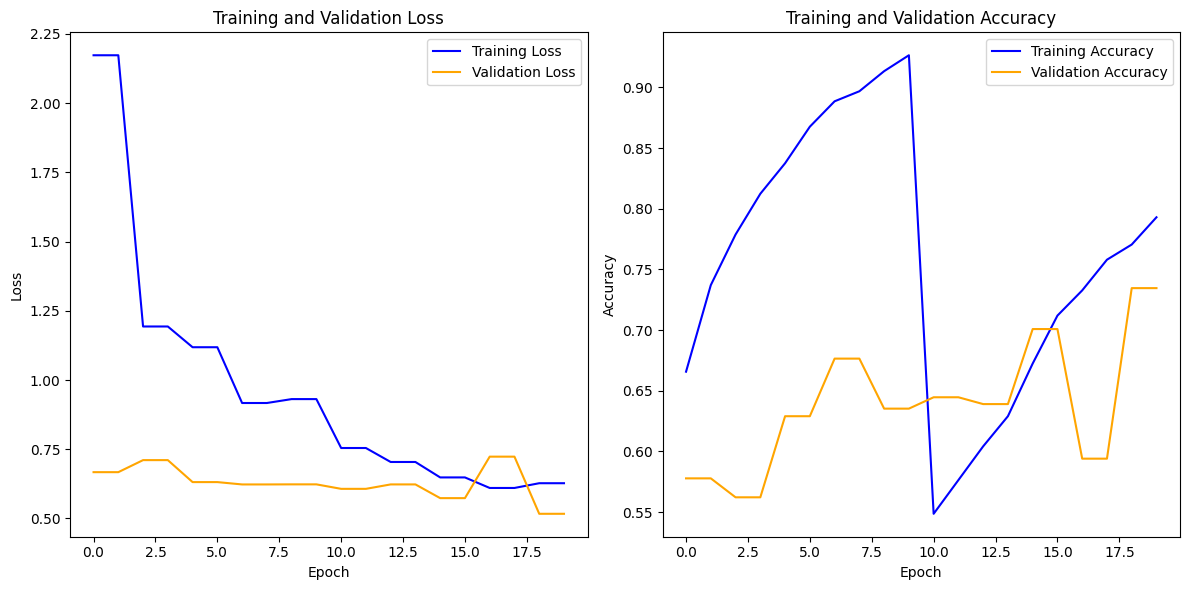

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.25)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.25)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(self.relu4(self.bn4(self.conv4(x)))))
        x = self.flatten(x)
        x = self.dropout5(self.relu5(self.bn5(self.fc1(x))))
        x = self.dropout6(self.relu6(self.bn6(self.fc2(x))))
        x = self.dropout7(self.relu7(self.bn7(self.fc3(x))))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.000001, weight_decay=0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

model.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    scheduler.step()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

Epoch 1/10, Train Loss: 6.0657, Train Acc: 0.4997, Val Loss: 1.9904, Val Acc: 0.4772
Epoch 1/10, Train Loss: 6.0657, Train Acc: 0.4997, Val Loss: 1.9904, Val Acc: 0.4772
Epoch 2/10, Train Loss: 5.8532, Train Acc: 0.5105, Val Loss: 1.4700, Val Acc: 0.4841
Epoch 2/10, Train Loss: 5.8532, Train Acc: 0.5105, Val Loss: 1.4700, Val Acc: 0.4841
Epoch 3/10, Train Loss: 5.7389, Train Acc: 0.5184, Val Loss: 1.3786, Val Acc: 0.5116
Epoch 3/10, Train Loss: 5.7389, Train Acc: 0.5184, Val Loss: 1.3786, Val Acc: 0.5116
Epoch 4/10, Train Loss: 5.6508, Train Acc: 0.5248, Val Loss: 1.2686, Val Acc: 0.5209
Epoch 4/10, Train Loss: 5.6508, Train Acc: 0.5248, Val Loss: 1.2686, Val Acc: 0.5209
Epoch 5/10, Train Loss: 5.5130, Train Acc: 0.5280, Val Loss: 1.2540, Val Acc: 0.5234
Epoch 5/10, Train Loss: 5.5130, Train Acc: 0.5280, Val Loss: 1.2540, Val Acc: 0.5234
Epoch 6/10, Train Loss: 5.4436, Train Acc: 0.5301, Val Loss: 1.2857, Val Acc: 0.5378
Epoch 6/10, Train Loss: 5.4436, Train Acc: 0.5301, Val Loss: 1.28

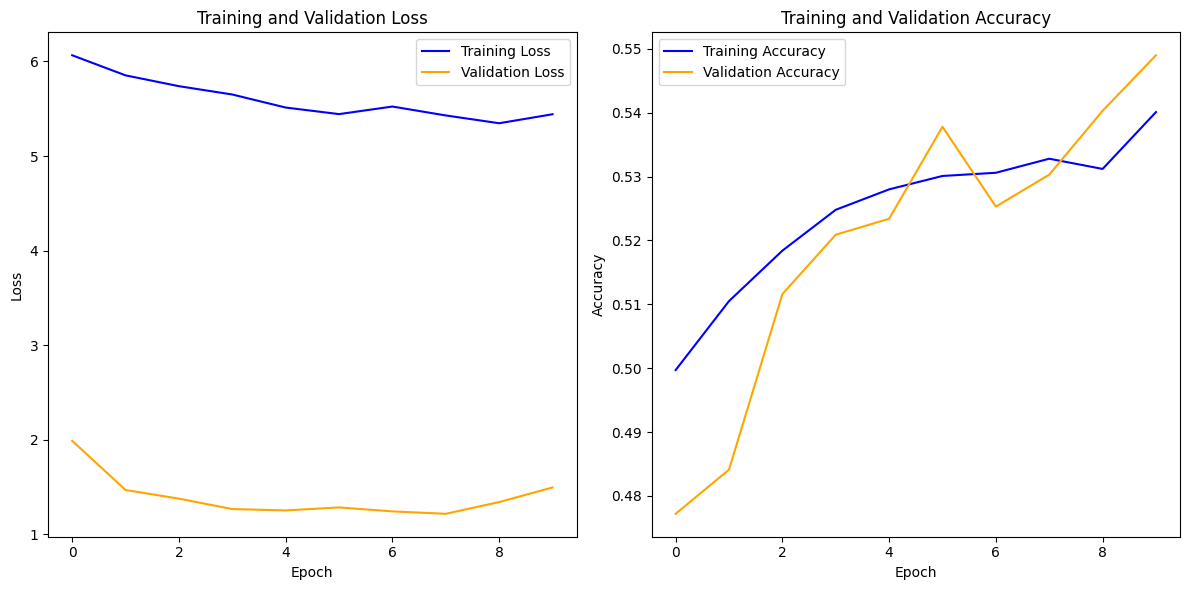

In [10]:
train_accuracies = [0.4997, 0.5105, 0.5184, 0.5248, 0.5280, 0.5301, 0.5306, 0.5328, 0.5312, 0.5401]
val_accuracies = [0.4772, 0.4841, 0.5116, 0.5209, 0.5234, 0.5378, 0.5253, 0.5303, 0.5403, 0.5490]
train_losses = [6.0657, 5.8532, 5.7389, 5.6508, 5.5130, 5.4436, 5.5236, 5.4294, 5.3471, 5.4422]
val_losses = [1.9904, 1.4700, 1.3786, 1.2686, 1.2540, 1.2857, 1.2439, 1.2185, 1.3424, 1.4970]


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.25)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.25)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(self.relu4(self.bn4(self.conv4(x)))))
        x = self.flatten(x)
        x = self.dropout5(self.relu5(self.bn5(self.fc1(x))))
        x = self.dropout6(self.relu6(self.bn6(self.fc2(x))))
        x = self.dropout7(self.relu7(self.bn7(self.fc3(x))))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.000001, weight_decay=0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

model.apply(weights_init)

criterion = nn.BCEWithLogitsLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

#     print(f'Epoch {epoch + 1}/{num_epochs}, '
#           f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
#           f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    scheduler.step()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

Epoch 1/20, Train Loss: 4.4839, Train Acc: 0.5014, Val Loss: 1.5389, Val Acc: 0.5359
Epoch 2/20, Train Loss: 4.5018, Train Acc: 0.4986, Val Loss: 1.3850, Val Acc: 0.5303
Epoch 3/20, Train Loss: 4.2580, Train Acc: 0.5248, Val Loss: 1.6714, Val Acc: 0.5259
Epoch 4/20, Train Loss: 4.1013, Train Acc: 0.5347, Val Loss: 1.8893, Val Acc: 0.5265
Epoch 5/20, Train Loss: 4.0896, Train Acc: 0.5292, Val Loss: 2.0938, Val Acc: 0.5222
Epoch 6/20, Train Loss: 3.9921, Train Acc: 0.5409, Val Loss: 2.9208, Val Acc: 0.5053
Epoch 7/20, Train Loss: 4.0947, Train Acc: 0.5336, Val Loss: 2.3284, Val Acc: 0.5141
Epoch 8/20, Train Loss: 3.9840, Train Acc: 0.5339, Val Loss: 2.1985, Val Acc: 0.5215
Epoch 9/20, Train Loss: 3.9865, Train Acc: 0.5362, Val Loss: 3.2110, Val Acc: 0.5003
Epoch 10/20, Train Loss: 3.9179, Train Acc: 0.5459, Val Loss: 2.3948, Val Acc: 0.5159
Epoch 11/20, Train Loss: 4.1034, Train Acc: 0.5389, Val Loss: 2.6725, Val Acc: 0.5084
Epoch 12/20, Train Loss: 3.9252, Train Acc: 0.5495, Val Loss: 2

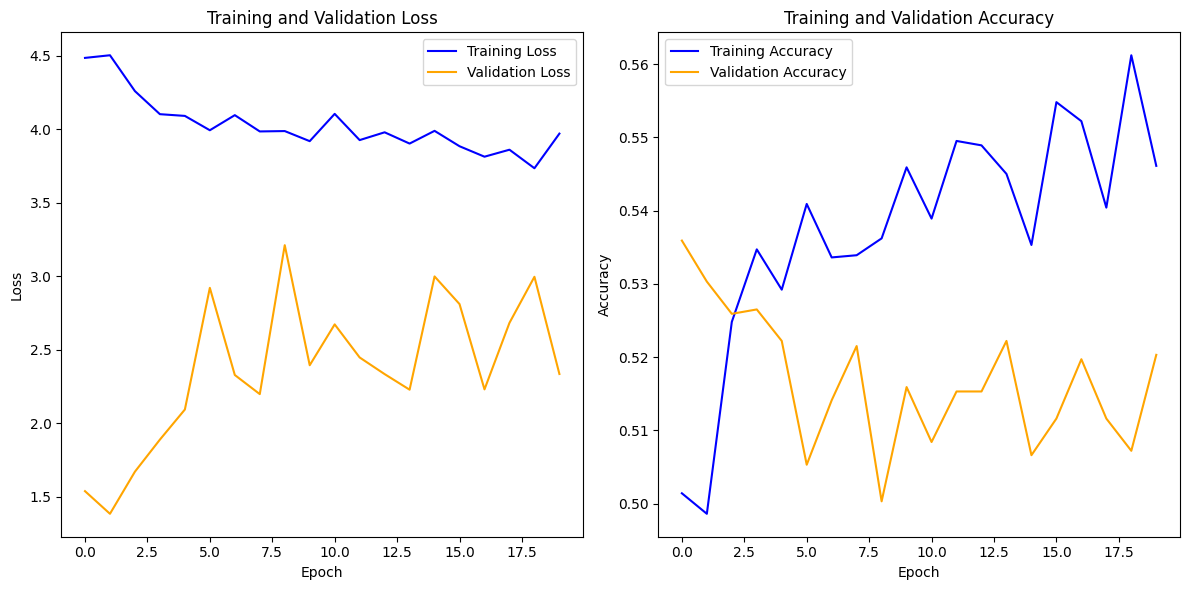

In [9]:
train_accuracies = [0.5014, 0.4986, 0.5248, 0.5347, 0.5292, 0.5409, 0.5336, 0.5339, 0.5362, 0.5459, 0.5389, 0.5495, 0.5489, 0.5450, 0.5353, 0.5548, 0.5522, 0.5404, 0.5612, 0.5461]
val_accuracies = [0.5359, 0.5303, 0.5259, 0.5265, 0.5222, 0.5053, 0.5141, 0.5215, 0.5003, 0.5159, 0.5084, 0.5153, 0.5153, 0.5222, 0.5066, 0.5116, 0.5197, 0.5116, 0.5072, 0.5203]

train_losses = [4.4839, 4.5018, 4.2580, 4.1013, 4.0896, 3.9921, 4.0947, 3.9840, 3.9865, 3.9179, 4.1034, 3.9252, 3.9781, 3.9015, 3.9880, 3.8834, 3.8123, 3.8598, 3.7338, 3.9692]
val_losses = [1.5389, 1.3850, 1.6714, 1.8893, 2.0938, 2.9208, 2.3284, 2.1985, 3.2110, 2.3948, 2.6725, 2.4476, 2.3345, 2.2286, 2.9984, 2.8105, 2.2307, 2.6829, 2.9960, 2.3353]


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.25)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.25)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.25)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 14 * 14, 512)
        self.bn5 = nn.BatchNorm1d(512)
        self.relu5 = nn.ReLU()
        self.dropout5 = nn.Dropout(0.25)

        self.fc2 = nn.Linear(512, 256)
        self.bn6 = nn.BatchNorm1d(256)
        self.relu6 = nn.ReLU()
        self.dropout6 = nn.Dropout(0.25)

        self.fc3 = nn.Linear(256, 128)
        self.bn7 = nn.BatchNorm1d(128)
        self.relu7 = nn.ReLU()
        self.dropout7 = nn.Dropout(0.25)

        self.fc4 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool1(self.dropout1(self.relu1(self.bn1(self.conv1(x)))))
        x = self.pool2(self.dropout2(self.relu2(self.bn2(self.conv2(x)))))
        x = self.pool3(self.dropout3(self.relu3(self.bn3(self.conv3(x)))))
        x = self.pool4(self.dropout4(self.relu4(self.bn4(self.conv4(x)))))
        x = self.flatten(x)
        x = self.dropout5(self.relu5(self.bn5(self.fc1(x))))
        x = self.dropout6(self.relu6(self.bn6(self.fc2(x))))
        x = self.dropout7(self.relu7(self.bn7(self.fc3(x))))
        x = self.fc4(x)

        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=0.000001, weight_decay=0.000001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  


criterion = nn.BCEWithLogitsLoss()

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
test_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        

#         nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        total_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1).float()).sum().item()
        total_train += labels.size(0)

    train_loss = total_loss / len(train_loader)
    train_accuracy = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_val += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_val += labels.size(0)

    val_accuracy = correct_val / total_val
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

#     print(f'Epoch {epoch + 1}/{num_epochs}, '
#           f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
#           f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    scheduler.step()
    correct_test = 0
    total_test = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            test_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1).float()).sum().item()
            total_test += labels.size(0)
    test_accuracy = correct_test / total_test
    test_loss /= len(test_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
print(f'Final Test Loss: {test_loss:.4f}, Final Test Acc: {test_accuracy:.4f}')

Epoch 1/20, Train Loss: 0.6731, Train Acc: 0.5834, Val Loss: 0.7771, Val Acc: 0.4834
Epoch 2/20, Train Loss: 0.6421, Train Acc: 0.6369, Val Loss: 0.8105, Val Acc: 0.4834
Epoch 3/20, Train Loss: 0.6282, Train Acc: 0.6451, Val Loss: 0.8121, Val Acc: 0.4847
Epoch 4/20, Train Loss: 0.6085, Train Acc: 0.6688, Val Loss: 0.8281, Val Acc: 0.4847
Epoch 5/20, Train Loss: 0.6035, Train Acc: 0.6641, Val Loss: 0.8639, Val Acc: 0.4841
Epoch 6/20, Train Loss: 0.5940, Train Acc: 0.6874, Val Loss: 0.8763, Val Acc: 0.4834
Epoch 7/20, Train Loss: 0.5950, Train Acc: 0.6771, Val Loss: 0.8574, Val Acc: 0.4841
Epoch 8/20, Train Loss: 0.5847, Train Acc: 0.6924, Val Loss: 0.8871, Val Acc: 0.4841
Epoch 9/20, Train Loss: 0.5784, Train Acc: 0.7024, Val Loss: 0.9054, Val Acc: 0.4834
Epoch 10/20, Train Loss: 0.5760, Train Acc: 0.7038, Val Loss: 0.8671, Val Acc: 0.4847
Epoch 11/20, Train Loss: 0.5725, Train Acc: 0.7050, Val Loss: 0.8751, Val Acc: 0.4847
Epoch 12/20, Train Loss: 0.5713, Train Acc: 0.7052, Val Loss: 0